# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [3]:
np.random.seed(42)

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [4]:
PATH = "./data/"

In [5]:
train_data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv'))
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))

In [6]:
train_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [7]:
test_data.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [8]:
# total males and females
train_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [9]:
# survived males and females
train_data[train_data['Survived']==1]['Sex'].value_counts()

female    233
male      109
Name: Sex, dtype: int64

Survived :
 female    233
male      109
Name: Sex, dtype: int64
Deceased:
 male      468
female     81
Name: Sex, dtype: int64


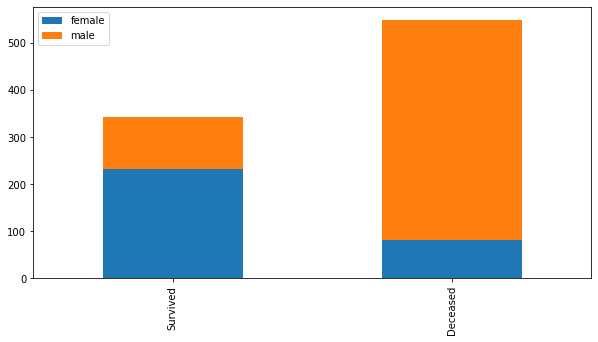

In [10]:
# let's visualize the relationship between gender and survival
survived = train_data[train_data['Survived']==1]['Sex'].value_counts()
deceased = train_data[train_data['Survived']==0]['Sex'].value_counts()
df = pd.DataFrame([survived, deceased])
df.index = ['Survived','Deceased']
df.plot(kind='bar',stacked=True, figsize=(10,5))
print("Survived :\n", train_data[train_data['Survived']==1]['Sex'].value_counts())
print("Deceased:\n", train_data[train_data['Survived']==0]['Sex'].value_counts())

<b> Seems like women are much more likely to survive than men. The ratio  deceased/survived for men is ~4.7:1 and for women is 1:3, so an average woman is ca. 4 times more likely to survive than an average man.</b>

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

[(0.0, 100.0), Text(0.5, 1.0, "Distribution of Passengers' Age")]

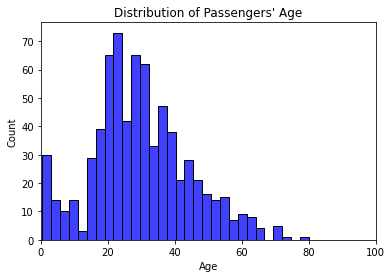

In [11]:
# let's construct a histogram for Age distribution
hist = sns.histplot(train_data['Age'], color='b', bins=30, kde=False)
hist.set(xlim=(0, 100), title = "Distribution of Passengers' Age")

In [12]:
# Mean of the age variable depending on the survival status
print('Mean ages for the deceased and the survived')
print(train_data.Age.groupby(train_data['Survived']).mean())

Mean ages for the deceased and the survived
Survived
0    30.626179
1    28.343690
Name: Age, dtype: float64


In [13]:
# Median of the age variable depending on the survival status
print('Median ages for the deceased and the survived')
print(train_data.Age.groupby(train_data['Survived']).median())

Median ages for the deceased and the survived
Survived
0    28.0
1    28.0
Name: Age, dtype: float64


Text(0.5, 1.0, 'Age distribution for the Deceased')

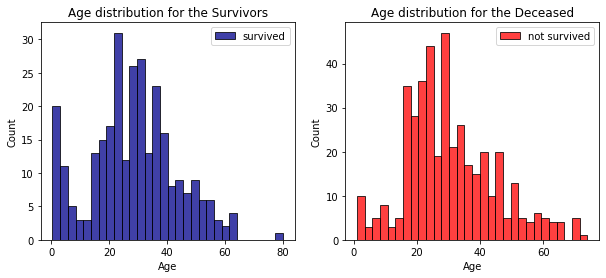

In [14]:
# Age distribution plots
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
ax = sns.histplot(train_data[train_data['Survived']==1].Age.dropna(), bins=30, label=survived, ax=axes[0], color='darkblue')
ax.legend()
ax.set_title('Age distribution for the Survivors')
ax = sns.histplot(train_data[train_data['Survived']==0].Age.dropna(), bins=30, label=not_survived, ax=axes[1], color='red')
ax.legend()
ax.set_title('Age distribution for the Deceased')

<b>As we can see from the plots and calculations, the median ages for the two groups are exactly the same, and the mean ages differ only slightly. Therefore, I believe that age itself is not enought important for the survival prediction, instead, we need to think about more complex factors like income/wealth or social background, like family or children. However, from the histograms we can see that you are probably more likely to survive if you are a young child (less than 5 years old). </b>

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

Survived :
 S    217
C     93
Q     30
Name: Embarked, dtype: int64
Deceased:
 S    427
C     75
Q     47
Name: Embarked, dtype: int64


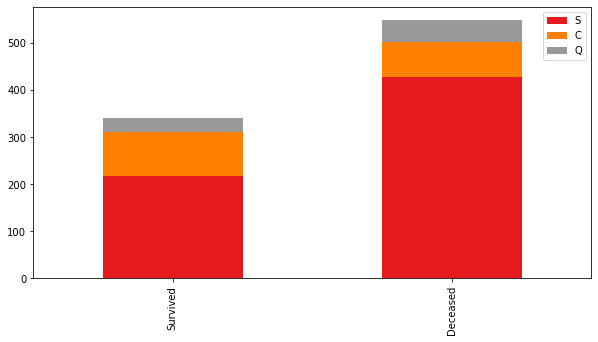

In [15]:
survived = train_data[train_data['Survived']==1]['Embarked'].value_counts()
deceased = train_data[train_data['Survived']==0]['Embarked'].value_counts()
df = pd.DataFrame([survived, deceased])
df.index = ['Survived','Deceased']
df.plot(kind='bar', stacked=True, figsize=(10,5), colormap='Set1')
print("Survived :\n", train_data[train_data['Survived']==1]['Embarked'].value_counts())
print("Deceased:\n", train_data[train_data['Survived']==0]['Embarked'].value_counts())

First, we can see that people embarked in Cherbourg are more likely to survive, while people embarked in Queenstown or Southampton are more likely to be dead.

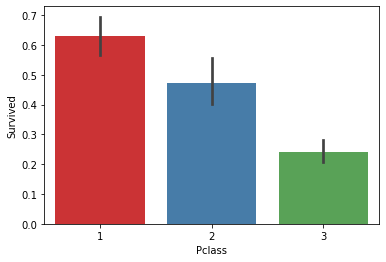

In [16]:
# let's explore Pclass variable
sns.barplot(x='Pclass', y='Survived', data=train_data, palette='Set1')

We can see clearly that the higher the class of the passenger was, the higher was the chance of survival (i.e., 1st class passengers were almost three times more likely to survive that 3rd class passengers).

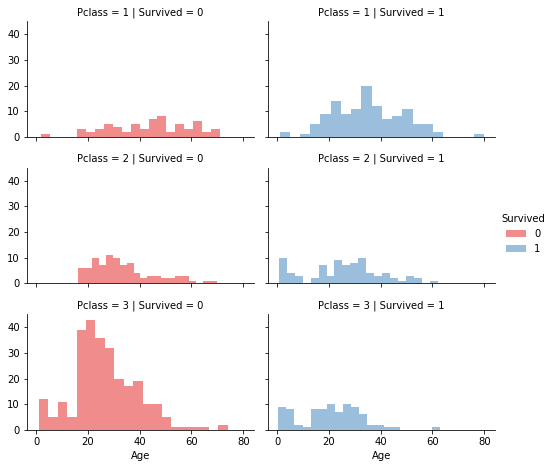

In [17]:
# let's take a closer look on a Pclass-Survived dependence
grid = sns.FacetGrid(train_data, col='Survived', row='Pclass', height=2.2, aspect=1.6, dropna=True, hue='Survived', palette='Set1')
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

<b>In general, we can see that not only the port of embarcation, but also the passenger's ticket class affect the chances of survival. From the grid barplots it is evident that 1st class passengers have the highest chances of survival, while 3rd class passenger is more likely to end up dead than alive.</b>

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [18]:
# for the sake of comfort we are doing to do preprocessing on the whole dataset (train and test combined)
whole_data = train_data.append(test_data, sort=True)

In [19]:
total_miss = whole_data.isnull().sum().sort_values(ascending=False)
pc_1 = whole_data.isnull().sum()/whole_data.isnull().count()*100
pc_2 = (round(pc_1, 1)).sort_values(ascending=False)
missing_vals = pd.concat([total_miss, pc_2], axis=1, keys=['Total', '%'])
missing_vals.head(7)

Total     %
Cabin      1014  77.5
Survived    418  31.9
Age         263  20.1
Embarked      2   0.2
Fare          1   0.1
Ticket        0   0.0
SibSp         0   0.0

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

We have to deal with three variables with missing values: Cabin (687), Embarked (2) and Age (177). 

#### Embarked
The Embarked variable is the easiest to deal with, we can just fill it with the most common value (it happens to be 'S'). As we have only two missing values, whatever way we choose to fill or drop them, it wouldn't significantly impact our model.

In [20]:
# finding the most common value
train_data['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [21]:
# we are doing to work with our whole dataset here, so we need to combine train and test 
whole_data['Embarked'] = whole_data['Embarked'].fillna('S')

# pasting Embarked values into train and test data
train_data['Embarked'] = whole_data['Embarked'][:891]
test_data['Embarked'] = whole_data['Embarked'][891:]

#### Fare

Here it's easy: we'll identify this passenger's class and fill his fare with median value for this class, as it's only one value in the whole dataset.

In [22]:
whole_data[whole_data.Fare.isnull()]

Age Cabin Embarked  Fare                Name  Parch  PassengerId  \
152  60.5   NaN        S   NaN  Storey, Mr. Thomas      0         1044   

     Pclass   Sex  SibSp  Survived Ticket  
152       3  male      0       NaN   3701

In [23]:
whole_data['Fare'].fillna(value = whole_data[whole_data.Pclass==3]['Fare'].median(), inplace = True)

#### Age

Next, we have to deal with 263 missing values in the Age variable. There is no use in dropping such a significant portion of data, and imputing it with mean age probably will skew the age distribution in passengers significantly. So we should do something smarter.
I suggest that we impute ages based on passenger's title. The idea here is quite clear: the age median for a woman with title Miss would probably be lower than for a woman with Mrs title. There is also a good chance that a person with a title Rev or Dr would be more likely to be in his 40s than about 10 years old. 
There are some titles that are quite rare, so first we should divide the titles from the initial dataset into broader groups, and after that impute median age values for different titles. 
It is probably not the most precise approach, but there is definetely some clear logic behind it, and I believe that this is an advantage in contrast to imputing some randomly generated age values, for example, or simply substitung age with global mean or median value.

In [24]:
# let's extract person's title first
# creating a Title column in the whole dataset
whole_data['Title'] = whole_data['Name']
# extracting Title from Name
for name in whole_data['Name']:
    whole_data['Title'] = whole_data['Name'].str.extract('([A-Za-z]+)\.', expand=True)
# let's see what we now have
whole_data['Title'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Major         2
Ms            2
Mlle          2
Don           1
Capt          1
Sir           1
Jonkheer      1
Lady          1
Countess      1
Dona          1
Mme           1
Name: Title, dtype: int64

In [25]:
# we need to replace rare titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss','Jonkheer': 'Mr',\
        'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
whole_data.replace({'Title': mapping}, inplace=True)
# now that's better
whole_data['Title'].value_counts()

Mr        767
Miss      265
Mrs       200
Master     61
Rev         8
Dr          8
Name: Title, dtype: int64

In [26]:
# next, age imputing by title median
titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']

for title in titles:
    age_to_impute = whole_data.groupby('Title')['Age'].median()[titles.index(title)]
    whole_data.loc[(whole_data['Age'].isnull()) & (whole_data['Title'] == title), 'Age'] = age_to_impute

In [27]:
# time to check if our replacement was successful
any(whole_data['Age'].isnull())

False

In [28]:
# inserting our new age values into train and test data
train_data['Age'] = whole_data['Age'][:891]
test_data['Age'] = whole_data['Age'][891:]

#### Cabin

Last but not least, we have 1000+ missing values in our Cabin variable. At first I thought about dropping the entire variable, but later I decided to try extracting some information from it.
I studied the dataset description and found out that the letter in not missing cabin numbers refers to a certain ship deck. For example, C12 cabin number states that a person had a cabin on the C deck, and different decks are probably somehow related to different chances of surviving, because the ship didn't sink as a whole in one minute.

So we are going to extract deck values as letters and convert them to numerical codes 1-7, and the missing deck values will be filled with 8, as we have no way of finding out where a particular person's cabin was located.

In [29]:
import re
# create deck values dictionary to convert them to numbers
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}

# creating new Deck variable in the whole data range
whole_data['Cabin'] = whole_data['Cabin'].fillna("U0")
whole_data['Deck'] = whole_data['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
whole_data['Deck'] = whole_data['Deck'].map(deck)
whole_data['Deck'] = whole_data['Deck'].fillna(0)
whole_data['Deck'] = whole_data['Deck'].astype(int)

whole_data['Deck'].value_counts()

8    1014
3      94
2      65
4      46
5      41
1      22
6      21
7       5
0       1
Name: Deck, dtype: int64

In [30]:
# time to check if our replacement was successful
any(whole_data['Deck'].isnull())

False

In [31]:
# inserting our new Deck variable into train and test data
train_data['Deck'] = whole_data['Deck'][:891]
test_data['Deck'] = whole_data['Deck'][891:]

# we can now drop extra Cabin feature
whole_data.drop('Cabin', axis = 1, inplace = True)
train_data.drop(['Cabin'], axis=1, inplace = True)
test_data.drop(['Cabin'], axis=1, inplace = True)

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

<b> In the previous step I have already completed some data transformations related to missing values in Cabin, Age and Embarked varibles.  Let's continue on feature preparation. </b>

In [32]:
# let's merge our SibSp and ParCh variables into a single family size variable
whole_data['FamSize'] = whole_data['Parch'] + whole_data['SibSp']

# inputing Famsize values in train and test data:
train_data['FamSize'] = whole_data['FamSize'][:891]
test_data['FamSize'] = whole_data['FamSize'][891:]

In [33]:
# label encoding for binary Sex variable
train_data['Sex'].replace(['male', 'female'], [0, 1], inplace=True)
test_data['Sex'].replace(['male', 'female'], [0, 1], inplace=True)

In [34]:
# creating categorical feature for Age variable using qcut function to distribute the values for categories
whole_data['AgeBin'] = pd.qcut(whole_data['Age'], 6)

label = LabelEncoder()
whole_data['Age_Code'] = label.fit_transform(whole_data['AgeBin'])

train_data['Age'] = whole_data['Age_Code'][:891]
test_data['Age'] = whole_data['Age_Code'][891:]

In [35]:
# and now we have encoded ages
train_data['Age'].value_counts()

2    251
0    168
1    149
5    143
4    143
3     37
Name: Age, dtype: int64

In [36]:
# convert embarked into numeric
ports = {"S": 0, "C": 1, "Q": 2}
whole_data['Embarked'] = whole_data['Embarked'].map(ports)

train_data['Embarked'] = whole_data['Embarked'][:891]
test_data['Embarked'] = whole_data['Embarked'][891:]

In [37]:
# make Fare a categorical feature using qcut() function to split categories evenly

whole_data['FareBin'] = pd.qcut(whole_data['Fare'], 5)

label = LabelEncoder()
whole_data['Fare_Code'] = label.fit_transform(whole_data['FareBin'])

train_data['Fare'] = whole_data['Fare_Code'][:891]
test_data['Fare'] = whole_data['Fare_Code'][891:]

In [38]:
# convert title to categorical variable
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
whole_data['Title'] = whole_data['Title'].replace(['Dr', 'Rev'], 'Rare')
whole_data['Title'] = whole_data['Title'].map(titles)
# filling NaN with 0, just to be safe
whole_data['Title'] = whole_data['Title'].fillna(0)

train_data['Title'] = whole_data['Title'][:891]
test_data['Title'] = whole_data['Title'][891:]

In [39]:
# let's drop some extra features we are unable to encode or we have already extracted information from them
train_data.drop(['Name', 'SibSp', 'Parch', 'Ticket', 'PassengerId'], axis = 1, inplace = True)
test_data.drop(['Name', 'SibSp', 'Parch', 'Ticket', 'PassengerId'], axis = 1, inplace = True)

In [40]:
# train and test data
y = train_data['Survived']
X_train = train_data.drop('Survived', 1)
X_test = test_data.copy()

In [41]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, y) * 100, 2)

In [42]:
#kNN
knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(X_train, y)  
Y_pred = knn.predict(X_test)  
acc_knn = round(knn.score(X_train, y) * 100, 2)

In [43]:
# results
print(f'Logistic regression accuracy is {acc_log}')
print(f'k Nearest Neighbors accuracy is {acc_knn}')

Logistic regression accuracy is 81.59
k Nearest Neighbors accuracy is 86.42


In [44]:
# let's add cross validation to our models

logreg_scores = cross_val_score(logreg, X_train, y, cv=10, scoring = "accuracy")
print('Logistic Regression with 10-fold cross validation')
print("Mean:", round(logreg_scores.mean(), 3))
print("Standard Deviation:", round(logreg_scores.std(), 3))

Logistic Regression with 10-fold cross validation
Mean: 0.813
Standard Deviation: 0.024


In [45]:
knn_scores = cross_val_score(knn, X_train, y, cv=10, scoring = "accuracy")
print('kNN with 10-fold cross validation')
print("Mean:", round(knn_scores.mean(), 3))
print("Standard Deviation:", round(knn_scores.std(), 3))

kNN with 10-fold cross validation
Mean: 0.804
Standard Deviation: 0.061


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [46]:
# let's create a feature combining Age and Pclass to see if the young and wealthy are more likely to survive
whole_data['Age_Class'] = whole_data['Age']* whole_data['Pclass']

train_data['Age_Class'] = whole_data['Age_Class'][:891]
test_data['Age_Class'] = whole_data['Age_Class'][891:]

In [47]:
# also I suggest we add some information on the family survival as it would probably be easier 
# to survive with the help of your loved ones

whole_data['Last_Name'] = whole_data['Name'].apply(lambda x: str.split(x, ",")[0])
default_chance = 0.5
whole_data['Family_Survival'] = default_chance
for grp, grp_df in whole_data[['Survived', 'Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age']].groupby(['Last_Name', 'Fare']):
     if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                whole_data.loc[whole_data['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin == 0.0):
                whole_data.loc[whole_data['PassengerId'] == passID, 'Family_Survival'] = 0

print(f"Number of passengers with data on family survival: {whole_data.loc[whole_data['Family_Survival']!=0.5].shape[0]}")

Number of passengers with data on family survival: 420


In [48]:
for _, grp_df in whole_data.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    whole_data.loc[whole_data['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    whole_data.loc[whole_data['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print(f"Number of passenger with family or group survival data: {(whole_data[whole_data['Family_Survival']!=0.5].shape[0])}")

Number of passenger with family or group survival data: 546


In [49]:
train_data['Family_Survival'] = whole_data['Family_Survival'][:891]
test_data['Family_Survival'] = whole_data['Family_Survival'][891:]

In [50]:
# let's take a look at our data 
train_data.head(10)

Survived  Pclass  Sex  Age  Fare  Embarked  Deck  FamSize  Title  \
0         0       3    0    1     0         0     8        1      1   
1         1       1    1    4     4         1     3        1      3   
2         1       3    1    2     1         0     8        0      2   
3         1       1    1    4     4         0     3        1      3   
4         0       3    0    4     1         0     8        0      1   
5         0       3    0    2     1         2     8        0      1   
6         0       1    0    5     4         0     5        0      1   
7         0       3    0    0     2         0     8        4      4   
8         1       3    1    2     2         0     8        2      3   
9         1       2    1    0     3         1     8        1      3   

   Age_Class  Family_Survival  
0       66.0              0.5  
1       38.0              0.5  
2       78.0              0.5  
3       35.0              0.0  
4      105.0              0.5  
5       90.0              0.5  
6       54.0              0.5  
7        6.0              0.0  
8       81.0              1.0  
9       28.0              0.0

In [51]:
# train and test data
y = train_data['Survived']
X_train = train_data.drop('Survived', 1)
X_test = test_data.copy()

In [52]:
# scaling features
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [53]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [54]:
# grid search
clf = KNeighborsClassifier()
params = {'n_neighbors':list(range(1, 20, 2)),
         'leaf_size':list(range(1,50,5))}

gs = GridSearchCV(clf, param_grid= params, cv=5,scoring = "accuracy", verbose=True)
gs.fit(X_train, y)
print(gs.best_score_)
print(gs.best_estimator_)
print(gs.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
0.8417362375243236
KNeighborsClassifier(leaf_size=6, n_neighbors=9)
{'leaf_size': 6, 'n_neighbors': 9}


In [55]:
clf = KNeighborsClassifier(n_neighbors=9, leaf_size=6)

In [56]:
clf.fit(X_train, y)
prediction = clf.predict(X_test)

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [57]:
temp = pd.DataFrame(pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))['PassengerId'])
temp['Survived'] = prediction
temp.to_csv("submission.csv", index = False)

<b>This dataset is somehow an enigma to me: you can simply train a model on the gender column and get rather OK score, but then you make some features from scratch and try to think real hard and all you get is a score of like 0.65...
Anyway, we can see that being a rich young woman on Titanic is much luckier than being a rather poor man travelling alone. </b>

Kaggle leaderboard score: 0.78229

https://www.kaggle.com/k8isdead

Ekaterina Martynko


## Part 2: Porto Seguroâ€™s Safe Driver Prediction - TBD next week

In [58]:
## your code